In [453]:
import numpy as np
from StringIO import StringIO
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import urllib2,base64
import cPickle as pickle
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import geoplotlib as gp
import scipy as sp
import pysal as ps
import datetime
import operator
import re
import os
import os.path
import requests, time
import urllib, json
import csv
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
tls.set_credentials_file(username='ShawnHou', api_key='OohmqCJaPfb6p6xo4pDF')
from geoplotlib.utils import BoundingBox
from sklearn import neighbors, datasets,linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from pylab import *
from scipy import stats
from sklearn.neighbors import DistanceMetric
from urllib2 import urlopen, Request
from pprint import pprint
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from collections import defaultdict
from operator import itemgetter
from pushover import init, Client
from scipy.spatial import KDTree
from calendar import monthrange
%matplotlib inline

# Chapter 1. NOAA Data ETL : Advanced Project in Digital Media Engineering

- next chapter 2, about Twitter Data ETL, can be redirected from the link __[here](http://nbviewer.jupyter.org/github/ShawnHouCHN/Advanced-Project-in-Digital-Media-Engineering-E17/blob/master/notebooks/USA%20twitter%20data%20parser.ipynb)__ 

- next chapter 3, about data analysis, can be redirected from the link __[here](http://nbviewer.jupyter.org/github/ShawnHouCHN/Advanced-Project-in-Digital-Media-Engineering-E17/blob/master/notebooks/USA%20twitter-weather%20data%20analysis%20.ipynb)__ 
***
In this chapter, the notebook will show the extraction, transfer an. Some visualizations have been made to give a intuitvie insights of the result. <br>

## Motivation 

https://www.technologyreview.com/s/608961/billion-tweet-study-proves-we-write-happier-messages-when-the-weather-is-good/

## Data processing

### Voronoi Diagram

In [2]:
temp_stations = pd.read_csv(os.getcwd()+'\\data\\daily dataframe\\weather_station_list.csv',skipinitialspace=True)
temp_stations['GHCND']=temp_stations.GHCND.str.strip()
temp_stations=temp_stations[temp_stations.GHCND.str.contains("US")] ##Discard non US stations
temp_stations_clean=temp_stations[np.abs(temp_stations.LON-temp_stations.LON.mean())<=(5*temp_stations.LON.std())] ##discard OUTLIER by location

print "include outliner, size:",temp_stations.shape
print "exclude outliner, size:",temp_stations_clean.shape

include outliner, size: (56918, 6)
exclude outliner, size: (56911, 6)


In [3]:
##LOAD ALL YEARLY DATA INTO A DICTONARY (LONG EXECUTION TIM!!!!!!)

file_17=os.getcwd()+'\\data\\data option two\\2017.csv'
file_16=os.getcwd()+'\\data\\data option two\\2016.csv'
file_15=os.getcwd()+'\\data\\data option two\\2015.csv'
file_14=os.getcwd()+'\\data\\data option two\\2014.csv'
file_13=os.getcwd()+'\\data\\data option two\\2013.csv'
file_12=os.getcwd()+'\\data\\data option two\\2012.csv'
file_11=os.getcwd()+'\\data\\data option two\\2011.csv'
file_10=os.getcwd()+'\\data\\data option two\\2010.csv'
file_09=os.getcwd()+'\\data\\data option two\\2009.csv'
file_08=os.getcwd()+'\\data\\data option two\\2008.csv'
file_lib=[file_17,file_16,file_15,file_14,file_13,file_12,file_11,file_10,file_09,file_08]
file_data_dict=dict()
used_columns = [0,1,2,3,7]
data_columns = ['GHCND', 'DATE', 'ATTRIBUTE', 'VALUE', 'TIME']
dtypes = ['object']+['object']+['object']+[float, 'object']
for yearly_file, year in zip(file_lib,range(2017, 2007, -1)):
    yearly_data = pd.read_csv(yearly_file,header=None,usecols = used_columns,
                              dtype=dict(zip(used_columns, dtypes)),sep=',').rename(columns=dict(zip(used_columns, data_columns)))
    file_data_dict[year]=yearly_data

In [4]:
#data analysis based on 20160101 - 20161230

yearly_data=file_data_dict[2016]
date_rng=[d.strftime('%Y%m%d') for d in pd.date_range('2016-1-1', periods=366, freq='D')] #range from 6-1 to 7-30
daily_station_list=list()


In [306]:
#LONG EXECUTION TIME!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
for date in date_rng:
    daily_station=yearly_data[yearly_data['GHCND'].isin(temp_stations_clean['GHCND'].tolist())
                               & (yearly_data['DATE']==date) & (yearly_data['ATTRIBUTE'].isin(["TMAX"])) & (yearly_data['VALUE']!=-999) ]
    print date, " finished!"
    ##print "# of station reported in ",date," ",len(daily_station['GHCND'].unique().tolist())
    daily_station_list.append(daily_station['GHCND'].unique().tolist())

intersected_stations = set(daily_station_list[0]).intersection(*daily_station_list)
print "# of station reported from 20160101 to 20161231 ",len(intersected_stations)

20160101  finished!
20160102  finished!
20160103  finished!
20160104  finished!
20160105  finished!
20160106  finished!
20160107  finished!
20160108  finished!
20160109  finished!
20160110  finished!
20160111  finished!
20160112  finished!
20160113  finished!
20160114  finished!
20160115  finished!
20160116  finished!
20160117  finished!
20160118  finished!
20160119  finished!
20160120  finished!
20160121  finished!
20160122  finished!
20160123  finished!
20160124  finished!
20160125  finished!
20160126  finished!
20160127  finished!
20160128  finished!
20160129  finished!
20160130  finished!
20160131  finished!
20160201  finished!
20160202  finished!
20160203  finished!
20160204  finished!
20160205  finished!
20160206  finished!
20160207  finished!
20160208  finished!
20160209  finished!
20160210  finished!
20160211  finished!
20160212  finished!
20160213  finished!
20160214  finished!
20160215  finished!
20160216  finished!
20160217  finished!
20160218  finished!
20160219  finished!


In [307]:
#For Voronoi graph, no county needed
reported_meta_stations=temp_stations_clean[temp_stations_clean['GHCND'].isin(intersected_stations)] 
reported_meta_stations.head(3100).to_csv('data\\daily dataframe\\stations_meta.csv', index=False)

In [310]:
daily_value_list=dict()
for date in date_rng:
    reported_data_stations=yearly_data[yearly_data['GHCND'].isin(list(intersected_stations)) & (yearly_data['DATE']==date) 
                                    & (yearly_data['ATTRIBUTE'].isin(["TMAX"])) & (yearly_data['VALUE']!=-999)]
    reported_full_stations=pd.merge(reported_meta_stations, reported_data_stations, on='GHCND', how='outer')
    daily_value_list[date]=reported_full_stations['VALUE'].tolist()
    print date, " finished!"

20160101  finished!
20160102  finished!
20160103  finished!
20160104  finished!
20160105  finished!
20160106  finished!
20160107  finished!
20160108  finished!
20160109  finished!
20160110  finished!
20160111  finished!
20160112  finished!
20160113  finished!
20160114  finished!
20160115  finished!
20160116  finished!
20160117  finished!
20160118  finished!
20160119  finished!
20160120  finished!
20160121  finished!
20160122  finished!
20160123  finished!
20160124  finished!
20160125  finished!
20160126  finished!
20160127  finished!
20160128  finished!
20160129  finished!
20160130  finished!
20160131  finished!
20160201  finished!
20160202  finished!
20160203  finished!
20160204  finished!
20160205  finished!
20160206  finished!
20160207  finished!
20160208  finished!
20160209  finished!
20160210  finished!
20160211  finished!
20160212  finished!
20160213  finished!
20160214  finished!
20160215  finished!
20160216  finished!
20160217  finished!
20160218  finished!
20160219  finished!


In [311]:
daily_value_df=pd.DataFrame.from_dict(daily_value_list,orient='index').transpose()
daily_value_df.sort_index(axis=1, inplace=True)
daily_value_df.head(3100).to_csv('data\\daily dataframe\\stations_values.csv', index=False)

## -----------------------------------------------------------------------------------------------------------------------------------
### County Level Diagram (Add County feature to each station)

#### Avoid reexecuting following section !!!! Due to connection to remote web service

In [ ]:
year="2016"
url_base = "http://data.fcc.gov/api/block/find?"
county_fips=list()
county_names=list()
block_fips=list()
print temp_stations_clean.shape
i=0
for index, row in temp_stations_clean.iterrows():
    lat=str(row['LAT'])
    lon=str(row['LON'])
    url_geo="latitude="+lat+"&"+"longitude="+lon+"&format=json"
    url=url_base+url_geo
    response = urllib.urlopen(url)
    data = json.loads(response.read())
    county_fips.append(data['County']['FIPS'])
    county_names.append(data['County']['name'])
    block_fips.append(data['Block']['FIPS'])
    i=i+1
    if i%1000==0:
        print i
    if i%15000==0:
        time.sleep(600)
        

county_fips_s = pd.Series(county_fips)
county_name_s = pd.Series(county_names)
block_fips_s = pd.Series(block_fips)
temp_stations_clean['COUNTY_CODE'] = county_fips_s.values
temp_stations_clean['COUNTY_NAME'] = county_name_s.values
temp_stations_clean['BLOCK_CODE'] = block_fips_s.values

In [39]:
temp_stations_clean.to_csv('data\\daily dataframe\\cleaned_weather_station_list_withCounty.csv', index=False,encoding="UTF-8")

#### Get average tem of each county in a specific date range (Some counties are missing)

In [5]:
temp_stations_clean=pd.read_csv('data\\daily dataframe\\cleaned_weather_station_list_withCounty.csv',skipinitialspace=True)

In [17]:
temp_stations_clean.dtypes

GHCND           object
LAT            float64
LON            float64
ELEV           float64
ST              object
NAME            object
COUNTY_CODE    float64
COUNTY_NAME     object
BLOCK_CODE     float64
dtype: object

In [21]:
daily_county_avg=defaultdict(dict)
for date in date_rng:
    reported_data_stations=yearly_data[(yearly_data['DATE']==date) & (yearly_data['ATTRIBUTE'].isin(["TMAX"])) & (yearly_data['VALUE']!=-999)]
    reported_full_stations=pd.merge(temp_stations_clean, reported_data_stations, on='GHCND', how='inner')
    reported_full_stations=reported_full_stations.groupby(['COUNTY_CODE'])['VALUE'].mean().reset_index().sort_values('COUNTY_CODE')
    reported_full_stations.VALUE=reported_full_stations.VALUE.round(2)
    reported_full_stations['COUNTY_CODE']=reported_full_stations['COUNTY_CODE'].astype(int).astype(str)
    for index, row in reported_full_stations.iterrows():
        daily_county_avg[row['COUNTY_CODE'].zfill(5)][date]=row['VALUE']
    
    print date, " finished!"

        
daily_county_avg=OrderedDict(sorted(daily_county_avg.items()))
    

#print daily_county_avg

20160101  finished!
20160102  finished!
20160103  finished!
20160104  finished!
20160105  finished!
20160106  finished!
20160107  finished!
20160108  finished!
20160109  finished!
20160110  finished!
20160111  finished!
20160112  finished!
20160113  finished!
20160114  finished!
20160115  finished!
20160116  finished!
20160117  finished!
20160118  finished!
20160119  finished!
20160120  finished!
20160121  finished!
20160122  finished!
20160123  finished!
20160124  finished!
20160125  finished!
20160126  finished!
20160127  finished!
20160128  finished!
20160129  finished!
20160130  finished!
20160131  finished!
20160201  finished!
20160202  finished!
20160203  finished!
20160204  finished!
20160205  finished!
20160206  finished!
20160207  finished!
20160208  finished!
20160209  finished!
20160210  finished!
20160211  finished!
20160212  finished!
20160213  finished!
20160214  finished!
20160215  finished!
20160216  finished!
20160217  finished!
20160218  finished!
20160219  finished!


#### Handle missing counties (Spatial Regression of a county with closest weather station inputs)

In [22]:
usa_counties_df = pd.read_csv(os.getcwd()+'\\data\\daily dataframe\\county_meta.csv',skipinitialspace=True)
usa_counties_df['FIPS'] = usa_counties_df['FIPS'].apply(lambda x: format(x, '05d'))

In [24]:
county_list=usa_counties_df.FIPS.tolist()
missing_county_list=list()
incomplete_county_list=list()

print "All in total reported from NOAA ", daily_county_avg.keys(), " size", len(daily_county_avg.keys()) 

for county_id in county_list:
    if county_id not in daily_county_avg.keys():
        missing_county_list.append(county_id)

print "All missing county FIPS from NOAA ", missing_county_list, " size", len(missing_county_list)


for key, value in daily_county_avg.items():
    if len(value.keys())!=len(date_rng):
        incomplete_county_list.append(key)
print "\n\n"       
print "All incomplete county FIPS from NOAA ", incomplete_county_list, " size", len(incomplete_county_list)

usa_missing_counties_df=usa_counties_df[usa_counties_df['FIPS'].isin(missing_county_list)]

All in total reported from NOAA  ['01003', '01005', '01007', '01009', '01011', '01013', '01015', '01017', '01019', '01021', '01025', '01029', '01031', '01033', '01035', '01037', '01039', '01041', '01043', '01045', '01047', '01049', '01051', '01053', '01055', '01057', '01059', '01061', '01063', '01065', '01067', '01071', '01073', '01075', '01077', '01079', '01081', '01083', '01089', '01091', '01093', '01095', '01097', '01101', '01103', '01107', '01109', '01111', '01113', '01117', '01121', '01123', '01125', '01127', '01129', '01131', '01133', '02013', '02016', '02020', '02050', '02060', '02068', '02090', '02100', '02105', '02110', '02122', '02130', '02150', '02164', '02170', '02180', '02185', '02188', '02195', '02198', '02220', '02230', '02240', '02261', '02270', '02275', '02282', '02290', '04001', '04003', '04005', '04007', '04009', '04011', '04012', '04013', '04015', '04017', '04019', '04021', '04023', '04025', '04027', '05001', '05003', '05005', '05007', '05009', '05017', '05019', '05

All missing county FIPS from NOAA  ['01001', '01023', '01027', '01069', '01085', '01087', '01099', '01105', '01115', '01119', '02070', '05011', '05013', '05015', '05141', '05147', '06101', '08014', '12019', '12067', '12125', '12131', '13003', '13013', '13017', '13019', '13023', '13027', '13029', '13035', '13037', '13047', '13053', '13057', '13061', '13067', '13079', '13083', '13097', '13099', '13101', '13103', '13107', '13109', '13111', '13119', '13125', '13129', '13135', '13141', '13143', '13149', '13155', '13157', '13161', '13165', '13169', '13171', '13173', '13181', '13183', '13189', '13193', '13197', '13199', '13201', '13209', '13211', '13217', '13225', '13231', '13237', '13247', '13249', '13255', '13259', '13265', '13269', '13273', '13275', '13279', '13283', '13287', '13289', '13297', '13307', '13309', '13313', '13315', '17005', '17007', '17009', '17013', '17017', '17035', '17039', '17047', '17059', '17065', '17087', '17093', '17117', '17123', '17125', '17133', '17147', '17165', '

#### Spatial Regression Handles

In [25]:
daily_county_avg_dfs=dict()
for date in date_rng:
    reported_data_stations=yearly_data[(yearly_data['DATE']==date) & (yearly_data['ATTRIBUTE'].isin(["TMAX"])) & (yearly_data['VALUE']!=-999)]
    reported_full_stations=pd.merge(temp_stations_clean, reported_data_stations, on='GHCND', how='inner')
    reported_avg_counties=reported_full_stations.groupby(['COUNTY_CODE'])['VALUE'].mean().reset_index().sort_values('COUNTY_CODE')
    reported_avg_counties.VALUE=reported_avg_counties.VALUE.round(2)
   
    reported_avg_counties['COUNTY_CODE'] = reported_avg_counties['COUNTY_CODE'].apply(lambda x: format(int(x), '05d'))

    ### Spatial regress on missing counties
    sample = reported_full_stations.loc[:, ['VALUE','LON','LAT']].dropna()
    w = ps.knnW_from_array(reported_full_stations.loc[sample.index,['LON','LAT']].values)
    w.transform = 'R'
    w_value = ps.knnW_from_array(reported_full_stations.loc[sample.index,['LON','LAT']].values)
    #sample_w = sample.assign(w_value=ps.lag_spatial(w_value, sample['VALUE'].values))
    m1 = ps.spreg.OLS(reported_full_stations['VALUE'].values[:,None], sample.drop('VALUE', axis=1).values, \
                  w=w, spat_diag=True, \
                  name_x=sample.drop('VALUE', axis=1).columns.tolist(), name_y='VALUE')
    coeffs= m1.betas
    #print m1.summary
    
    #for county in missing_county_list:
    for county in missing_county_list:
        if county not in reported_avg_counties['COUNTY_CODE'].tolist():
            county_lon = -float(usa_counties_df[usa_counties_df['FIPS']==county]['Longitude'].values[0].decode("utf-8", "ignore")[1:-1])
            county_lat = float(usa_counties_df[usa_counties_df['FIPS']==county]['Latitude'].values[0].decode("utf-8", "ignore")[1:-1])
            county_tam = coeffs[0] + coeffs[1] * county_lon + coeffs[2] * county_lat
            append_df = pd.DataFrame([[county, county_tam[0].round(2)]],columns=['COUNTY_CODE','VALUE'])
            reported_avg_counties=reported_avg_counties.append(append_df,ignore_index=True) 
        
    #for county in incomplete_county_list:
    for county in incomplete_county_list:
        if county not in reported_avg_counties['COUNTY_CODE'].tolist():
            county_lon = -float(usa_counties_df[usa_counties_df['FIPS']==county]['Longitude'].values[0].decode("utf-8", "ignore")[1:-1])
            county_lat = float(usa_counties_df[usa_counties_df['FIPS']==county]['Latitude'].values[0].decode("utf-8", "ignore")[1:-1])
            county_tam = coeffs[0] + coeffs[1] * county_lon + coeffs[2] * county_lat
            append_df = pd.DataFrame([[county, county_tam[0].round(2)]],columns=['COUNTY_CODE','VALUE'])
            reported_avg_counties=reported_avg_counties.append(append_df,ignore_index=True)  
          
    
    print reported_avg_counties.shape, " date: ", date
    
    reported_avg_counties=reported_avg_counties.sort_values('COUNTY_CODE')
    
    daily_county_avg_dfs[date]=reported_avg_counties['VALUE'].tolist()
    

(3143, 2)  date:  20160101
(3143, 2)  date:  20160102
(3143, 2)  date:  20160103
(3143, 2)  date:  20160104
(3143, 2)  date:  20160105
(3143, 2)  date:  20160106
(3143, 2)  date:  20160107
(3143, 2)  date:  20160108
(3143, 2)  date:  20160109
(3143, 2)  date:  20160110
(3143, 2)  date:  20160111
(3143, 2)  date:  20160112
(3143, 2)  date:  20160113
(3143, 2)  date:  20160114
(3143, 2)  date:  20160115
(3143, 2)  date:  20160116
(3143, 2)  date:  20160117
(3143, 2)  date:  20160118
(3143, 2)  date:  20160119
(3143, 2)  date:  20160120
(3143, 2)  date:  20160121
(3143, 2)  date:  20160122
(3143, 2)  date:  20160123
(3143, 2)  date:  20160124
(3143, 2)  date:  20160125
(3143, 2)  date:  20160126
(3143, 2)  date:  20160127
(3143, 2)  date:  20160128
(3143, 2)  date:  20160129
(3143, 2)  date:  20160130
(3143, 2)  date:  20160131
(3143, 2)  date:  20160201
(3143, 2)  date:  20160202
(3143, 2)  date:  20160203
(3143, 2)  date:  20160204
(3143, 2)  date:  20160205
(3143, 2)  date:  20160206
(

(3143, 2)  date:  20161031
(3143, 2)  date:  20161101
(3143, 2)  date:  20161102
(3143, 2)  date:  20161103
(3143, 2)  date:  20161104
(3143, 2)  date:  20161105
(3143, 2)  date:  20161106
(3143, 2)  date:  20161107
(3143, 2)  date:  20161108
(3143, 2)  date:  20161109
(3143, 2)  date:  20161110
(3143, 2)  date:  20161111
(3143, 2)  date:  20161112
(3143, 2)  date:  20161113
(3143, 2)  date:  20161114
(3143, 2)  date:  20161115
(3143, 2)  date:  20161116
(3143, 2)  date:  20161117
(3143, 2)  date:  20161118
(3143, 2)  date:  20161119
(3143, 2)  date:  20161120
(3143, 2)  date:  20161121
(3143, 2)  date:  20161122
(3143, 2)  date:  20161123
(3143, 2)  date:  20161124
(3143, 2)  date:  20161125
(3143, 2)  date:  20161126
(3143, 2)  date:  20161127
(3143, 2)  date:  20161128
(3143, 2)  date:  20161129
(3143, 2)  date:  20161130
(3143, 2)  date:  20161201
(3143, 2)  date:  20161202
(3143, 2)  date:  20161203
(3143, 2)  date:  20161204
(3143, 2)  date:  20161205
(3143, 2)  date:  20161206
(

In [26]:
#ADD FIPS code to each line of observations as index column. and save data
daily_county_avg_dfs['FIPS']=county_list
daily_county_avg_df=pd.DataFrame.from_dict(daily_county_avg_dfs,orient='index').transpose()
daily_county_avg_df.sort_index(axis=1, inplace=True)

daily_county_avg_df.to_csv('data\\daily dataframe\\county_values_sr.csv', index=False)

#### KNN Handles

In [27]:
daily_county_avg_knn_dfs=dict()
for date in date_rng:
    reported_data_knn_stations=yearly_data[(yearly_data['DATE']==date) & (yearly_data['ATTRIBUTE'].isin(["TMAX"])) & (yearly_data['VALUE']!=-999)]
    reported_full_knn_stations=pd.merge(temp_stations_clean, reported_data_knn_stations, on='GHCND', how='inner')
    reported_avg_knn_counties=reported_full_knn_stations.groupby(['COUNTY_CODE'])['VALUE'].mean().reset_index().sort_values('COUNTY_CODE')
    reported_avg_knn_counties.VALUE=reported_avg_knn_counties.VALUE.round(2)
   
    reported_avg_knn_counties['COUNTY_CODE'] = reported_avg_knn_counties['COUNTY_CODE'].apply(lambda x: format(int(x), '05d'))  
    
    #KNN models on missing data
    reported_train_knn_X=reported_full_knn_stations[['LAT','LON']].as_matrix()
    reported_train_knn_Y=reported_full_knn_stations[['VALUE']].as_matrix()
    neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')
    neigh.fit(reported_train_knn_X, reported_train_knn_Y.ravel()) 
    
    #for county in missing_county_list:
    for county in missing_county_list: 
        if county not in reported_avg_knn_counties['COUNTY_CODE'].tolist():
            county_lon = -float(usa_counties_df[usa_counties_df['FIPS']==county]['Longitude'].values[0].decode("utf-8", "ignore")[1:-1])
            county_lat = float(usa_counties_df[usa_counties_df['FIPS']==county]['Latitude'].values[0].decode("utf-8", "ignore")[1:-1])
            pre_tem=neigh.predict([[county_lat, county_lon]])[0]
            append_df = pd.DataFrame([[county, pre_tem.round(2)]],columns=['COUNTY_CODE','VALUE'])
            reported_avg_knn_counties=reported_avg_knn_counties.append(append_df,ignore_index=True) 
            
    #for county in incomplete_county_list:
    for county in incomplete_county_list:
        if county not in reported_avg_knn_counties['COUNTY_CODE'].tolist():
            county_lon = -float(usa_counties_df[usa_counties_df['FIPS']==county]['Longitude'].values[0].decode("utf-8", "ignore")[1:-1])
            county_lat = float(usa_counties_df[usa_counties_df['FIPS']==county]['Latitude'].values[0].decode("utf-8", "ignore")[1:-1])
            pre_tem=neigh.predict([[county_lat, county_lon]])[0]
            append_df = pd.DataFrame([[county, pre_tem.round(2)]],columns=['COUNTY_CODE','VALUE'])
            reported_avg_knn_counties=reported_avg_knn_counties.append(append_df,ignore_index=True) 
            
    print reported_avg_knn_counties.shape, " date: ", date
    
    reported_avg_knn_counties=reported_avg_knn_counties.sort_values('COUNTY_CODE')
    
    daily_county_avg_knn_dfs[date]=reported_avg_knn_counties['VALUE'].tolist()

(3143, 2)  date:  20160101
(3143, 2)  date:  20160102
(3143, 2)  date:  20160103
(3143, 2)  date:  20160104
(3143, 2)  date:  20160105
(3143, 2)  date:  20160106
(3143, 2)  date:  20160107
(3143, 2)  date:  20160108
(3143, 2)  date:  20160109
(3143, 2)  date:  20160110
(3143, 2)  date:  20160111
(3143, 2)  date:  20160112
(3143, 2)  date:  20160113
(3143, 2)  date:  20160114
(3143, 2)  date:  20160115
(3143, 2)  date:  20160116
(3143, 2)  date:  20160117
(3143, 2)  date:  20160118
(3143, 2)  date:  20160119
(3143, 2)  date:  20160120
(3143, 2)  date:  20160121
(3143, 2)  date:  20160122
(3143, 2)  date:  20160123
(3143, 2)  date:  20160124
(3143, 2)  date:  20160125
(3143, 2)  date:  20160126
(3143, 2)  date:  20160127
(3143, 2)  date:  20160128
(3143, 2)  date:  20160129
(3143, 2)  date:  20160130
(3143, 2)  date:  20160131
(3143, 2)  date:  20160201
(3143, 2)  date:  20160202
(3143, 2)  date:  20160203
(3143, 2)  date:  20160204
(3143, 2)  date:  20160205
(3143, 2)  date:  20160206
(

(3143, 2)  date:  20161031
(3143, 2)  date:  20161101
(3143, 2)  date:  20161102
(3143, 2)  date:  20161103
(3143, 2)  date:  20161104
(3143, 2)  date:  20161105
(3143, 2)  date:  20161106
(3143, 2)  date:  20161107
(3143, 2)  date:  20161108
(3143, 2)  date:  20161109
(3143, 2)  date:  20161110
(3143, 2)  date:  20161111
(3143, 2)  date:  20161112
(3143, 2)  date:  20161113
(3143, 2)  date:  20161114
(3143, 2)  date:  20161115
(3143, 2)  date:  20161116
(3143, 2)  date:  20161117
(3143, 2)  date:  20161118
(3143, 2)  date:  20161119
(3143, 2)  date:  20161120
(3143, 2)  date:  20161121
(3143, 2)  date:  20161122
(3143, 2)  date:  20161123
(3143, 2)  date:  20161124
(3143, 2)  date:  20161125
(3143, 2)  date:  20161126
(3143, 2)  date:  20161127
(3143, 2)  date:  20161128
(3143, 2)  date:  20161129
(3143, 2)  date:  20161130
(3143, 2)  date:  20161201
(3143, 2)  date:  20161202
(3143, 2)  date:  20161203
(3143, 2)  date:  20161204
(3143, 2)  date:  20161205
(3143, 2)  date:  20161206
(

In [28]:
#ADD FIPS code to each line of observations as index column. and save data
daily_county_avg_knn_dfs['FIPS']=county_list
daily_county_avg_knn_dfs=pd.DataFrame.from_dict(daily_county_avg_knn_dfs,orient='index').transpose()
daily_county_avg_knn_dfs.sort_index(axis=1, inplace=True)

daily_county_avg_knn_dfs.to_csv('data\\daily dataframe\\county_values_knn.csv', index=False)

### Twitter Data Ingestion

#### 1. LOAD WEATHER KEYWORDS

In [30]:
js = open('data\\daily dataframe\\keyword_map.json').read()
weather_keywords = json.loads(js)
print weather_keywords.keys()

[u'scalding', u'flaming', u'humid', u'hypothermic', u'shivering', u'scorched', u'nippy', u'balmy', u'steamy', u'frigorific', u'antarctic', u'wintry', u'ice-cold', u'shivery', u'sweltry', u'broiling', u'scorching', u'summery', u'icy-cold', u'siberian', u'arid', u'sweaty', u'tropical', u'hot', u'sweat-inducing', u'sweltering', u'bleak', u'ovenlike', u'stifling', u'glacial', u'heat-wave', u'steaming-hot', u'boiling-hot', u'baking-hot', u'afire', u'blistering', u'algid', u'chilled to the bone', u'snowy', u'white-hot', u'heatwave', u'arctic', u'blazing-hot', u'rimy', u'chilled-through', u'stinging-cold', u'freezing', u'warm', u'gelid', u'smoking', u'blizzardy', u'icy', u'conflagrant', u'sizzling', u'frozen-over', u'muggy', u'sub-zero', u'chilled', u'bitterly-cold', u'smoking-hot', u'frozen', u'torrid', u'blazing', u'red-hot', u'chilly', u'bitter-cold', u'parky', u'parching', u'numbing', u'numbing-cold', u'calescent', u'shiver-inducing', u'sultry', u'frosty']


#### 2. LOAD WEATHER COUNTY

In [36]:
temp_stations_tweets=pd.read_csv('data\\daily dataframe\\weather_keyword_counts.tsv',sep='\t', skipinitialspace=True, names=['DATE','RECORDS'], skiprows=1)
temp_stations_tweets.head()

,DATE,RECORDS
0,2016_01_01,"{""hot"": {""16079"": 0.3020231899698423, ""33017"":..."
1,2016_01_02,"{""hot"": {""16079"": 0.20134879331322816, ""33017""..."
2,2016_01_03,"{""hot"": {""16079"": 0.6507980323282503, ""40135"":..."
3,2016_01_04,"{""cold"": {""16079"": 0.03355813221887136, ""40135..."
4,2016_01_05,"{""hot"": {""16079"": 0.44944923901502215, ""40135""..."


In [220]:
daily_county_hottweets_dict=defaultdict(dict)
daily_county_coldtweets_dict=defaultdict(dict)
for index, row in temp_stations_tweets.iterrows():
    record_object=json.loads(row.RECORDS)
    record_date=row.DATE
    record_object['hot']= {format(int(k), '05d'):round(v,2) for k,v in record_object['hot'].items()}
    record_object['cold']= {format(int(k), '05d'):round(v,2) for k,v in record_object['cold'].items()}
    daily_county_hottweets=OrderedDict(sorted(record_object['hot'].items()))
    daily_county_coldtweets=OrderedDict(sorted(record_object['cold'].items()))
    
    
    record_date=record_date.replace('_','');
    
    for county in county_list:
        if county in daily_county_hottweets.keys():
            daily_county_hottweets_dict[record_date][county]=daily_county_hottweets[county]
        if county in daily_county_coldtweets.keys():
            daily_county_coldtweets_dict[record_date][county]=daily_county_coldtweets[county]
    
    
    print record_date, " finished!"
    

20160101  finished!
20160102  finished!
20160103  finished!
20160104  finished!
20160105  finished!
20160106  finished!
20160107  finished!
20160108  finished!
20160109  finished!
20160110  finished!
20160111  finished!
20160112  finished!
20160113  finished!
20160114  finished!
20160115  finished!
20160116  finished!
20160117  finished!
20160118  finished!
20160119  finished!
20160120  finished!
20160121  finished!
20160122  finished!
20160123  finished!
20160124  finished!
20160125  finished!
20160126  finished!
20160127  finished!
20160128  finished!
20160129  finished!
20160130  finished!
20160131  finished!
20160201  finished!
20160202  finished!
20160203  finished!
20160204  finished!
20160205  finished!
20160206  finished!
20160207  finished!
20160208  finished!
20160209  finished!
20160210  finished!
20160211  finished!
20160212  finished!
20160213  finished!
20160214  finished!
20160215  finished!
20160216  finished!
20160217  finished!
20160218  finished!
20160219  finished!


In [221]:
for hot_key,hot_value in daily_county_hottweets_dict.iteritems():    
     daily_county_hottweets_dict[hot_key]=OrderedDict(sorted(hot_value.items()))
for cold_key,cold_value in daily_county_coldtweets_dict.iteritems():    
     daily_county_coldtweets_dict[cold_key]=OrderedDict(sorted(cold_value.items()))
        
daily_county_hottweets_dict=OrderedDict(sorted(daily_county_hottweets_dict.items()))
daily_county_coldtweets_dict=OrderedDict(sorted(daily_county_coldtweets_dict.items()))

In [223]:
most_tweet_hot_county_list=list()
most_tweet_hot_county_dict=dict()
for value in daily_county_hottweets_dict.values():
    most_tweet_hot_county_list.append(max(value.iteritems(), key=operator.itemgetter(1))[0])

print "Daily summary of counties with higest amount of hot-related tweets"
count_hot_counties=Counter(most_tweet_hot_county_list)
for key, value in count_hot_counties.items():
    most_tweet_hot_county_dict[key] = value
print count_hot_counties


most_tweet_cold_county_list=list()
most_tweet_cold_county_dict=dict()
for value in daily_county_coldtweets_dict.values():
    most_tweet_cold_county_list.append(max(value.iteritems(), key=operator.itemgetter(1))[0])

print "\nDaily summary of counties with higest amount of cold-related tweets"
count_cold_counties=Counter(most_tweet_cold_county_list)
for key, value in count_cold_counties.items():
    most_tweet_cold_county_dict[key] = value
print count_cold_counties

Daily summary of counties with higest amount of hot-related tweets
Counter({'20063': 173, '31099': 66, '06037': 37, '06085': 28, '28143': 22, '35017': 20, '12086': 5, '30091': 4, '46015': 3, '30015': 2, '50015': 2, '45013': 1, '31115': 1, '08105': 1, '06081': 1})

Daily summary of counties with higest amount of cold-related tweets
Counter({'31099': 298, '28143': 10, '31115': 9, '06085': 9, '30015': 8, '24510': 6, '30091': 5, '06001': 3, '54001': 3, '24003': 2, '06081': 2, '41051': 1, '53061': 1, '25017': 1, '06071': 1, '36061': 1, '56021': 1, '41005': 1, '25027': 1, '46015': 1, '38007': 1, '23005': 1})


In [225]:
#Put 0 to the county with no tweets about weather
for key, value in daily_county_hottweets_dict.iteritems():
    county_set_with_tweets=set(value.keys())
    missing_county_list=list(set(county_list)-county_set_with_tweets)
    listofzeros = [0] * len(missing_county_list)
    value.update(zip(missing_county_list,listofzeros))
    daily_county_hottweets_dict[key]=OrderedDict(sorted(value.items()))
    
for key, value in daily_county_coldtweets_dict.iteritems():
    county_set_with_tweets=set(value.keys())
    missing_county_list=list(set(county_list)-county_set_with_tweets)
    listofzeros = [0] * len(missing_county_list)
    value.update(zip(missing_county_list,listofzeros))
    daily_county_coldtweets_dict[key]=OrderedDict(sorted(value.items()))


#### 3. Save transformed tweets data into csv file

In [234]:
#save daily value of each county into a csv file
csv_list=list()
for county_daily in daily_county_hottweets_dict.values():
    csv_list.append(county_daily.values())   

rows = zip(*csv_list)  
county_hot_df = pd.DataFrame(rows, columns=daily_county_hottweets_dict.keys())
county_hot_df['FIPS']=county_list
with open('county_value_hot.csv','wb') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(daily_county_hottweets_dict.keys())
    for row in rows:
        csv_out.writerow(row)

        
#save daily value of each county into a csv file
csv_list=list()
for county_daily in daily_county_coldtweets_dict.values():
    csv_list.append(county_daily.values())   

rows = zip(*csv_list)  
county_cold_df = pd.DataFrame(rows, columns=daily_county_coldtweets_dict.keys())
county_cold_df['FIPS']=county_list
with open('county_value_cold.csv','wb') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(daily_county_coldtweets_dict.keys())
    for row in rows:
        csv_out.writerow(row)

#### Compute potential correlation among TMAX / HOT / COLD

In [306]:
pear_hot_list=list()
spear_hot_list=list()
pear_cold_list=list()
spear_cold_list=list()

for index, row in county_hot_df.iterrows():
    nonzeros= np.count_nonzero(np.array(row.tolist()[:-1]))
    county_tmaxs = daily_county_avg_knn_dfs[daily_county_avg_knn_dfs['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    county_tmaxs = np.array(baldwin_tmaxs)
    if nonzeros >= round(len(county_hot_df.columns)*0.3):
        pear_hot=sp.stats.pearsonr(county_tmaxs,row.tolist()[:-1])[0]
        spear_hot=sp.stats.spearmanr(county_tmaxs,row.tolist()[:-1])[0]
    else:
        pear_hot=0
        spear_hot=0
        
    pear_hot_list.append(pear_hot)
    spear_hot_list.append(spear_hot)

for index, row in county_cold_df.iterrows():
    nonzeros= np.count_nonzero(np.array(row.tolist()[:-1]))
    county_tmaxs = daily_county_avg_knn_dfs[daily_county_avg_knn_dfs['FIPS']==row.tolist()[-1]].values.tolist()[0][:-1]
    county_tmaxs = np.array(baldwin_tmaxs)
    if nonzeros >= round(len(county_cold_df.columns)*0.3):
        pear_cold=sp.stats.pearsonr(county_tmaxs,row.tolist()[:-1])[0]
        spear_cold=sp.stats.spearmanr(county_tmaxs,row.tolist()[:-1])[0]
    else:
        pear_cold=0
        spear_cold=0
        
    pear_cold_list.append(pear_cold)
    spear_cold_list.append(spear_cold)

correlation_df = pd.DataFrame({'PEAR HOT':pear_hot_list, 'SPEAR HOT':spear_hot_list,'PEAR COLD':pear_cold_list,'SPEAR COLD':spear_cold_list})


In [307]:
print "Correlation of each county pearson tmax - hot, tmax - cold, spearman tmax- hot, tmax - cold \n "

print correlation_df.describe()

##add additional FIPS columns for map matching
county_int_list = map(int, county_list)
correlation_df['FIPS']=county_int_list

Correlation of each county pearson tmax - hot, tmax - cold, spearman tmax- hot, tmax - cold 
 
         PEAR COLD     PEAR HOT   SPEAR COLD    SPEAR HOT
count  3143.000000  3143.000000  3143.000000  3143.000000
mean     -0.103472     0.250618    -0.115460     0.165668
std       0.092353     0.133201     0.096940     0.139393
min      -0.396993    -0.247926    -0.382906    -0.265525
25%      -0.168583     0.170854    -0.183021     0.069666
50%      -0.111246     0.263223    -0.125811     0.168181
75%      -0.040727     0.342330    -0.054830     0.263693
max       0.261448     0.569367     0.296647     0.566986


In [311]:
topo_path = r'data/daily dataframe/us-10m.json'

#with open(topo_path, 'r') as f:
#    get_id = json.load(f)

#print get_id['objects']['counties']['geometries']
correlate_hot_map = folium.Map(location=[39.8282, -98.5795], zoom_start=4)
correlate_hot_map.choropleth(topo_path, data=correlation_df,columns=['FIPS','PEAR HOT'],topojson='objects.counties',
                         key_on='feature.id',
                         fill_color='YlOrRd',
                         line_weight=0.1, fill_opacity=0.3)


print "Correlation rate between TMAX and HOT counts in each county in period of 2016"
correlate_hot_map

Correlation rate between TMAX and HOT counts in each county in period of 2016


In [319]:
topo_path = r'data/daily dataframe/us-10m.json'

#with open(topo_path, 'r') as f:
#    get_id = json.load(f)

#print get_id['objects']['counties']['geometries']
correlate_map = l.Map(location=[39.8282, -98.5795], zoom_start=4)
correlate_map.choropleth(topo_path, data=correlation_df,columns=['FIPS','PEAR COLD'],topojson='objects.counties',
                         key_on='feature.id',
                         fill_color='RdYlBu',
                         line_weight=0.1, fill_opacity=0.3)


print "Correlation rate between TMAX and COLD counts in each county in period of 2016"
correlate_map

Correlation rate between TMAX and COLD counts in each county in period of 2016


In [454]:
county_hot_top_df['NAME']=county_name_top_list
county_cold_top_df['NAME']=county_name_top_list

C:\WorkingGround\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\WorkingGround\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



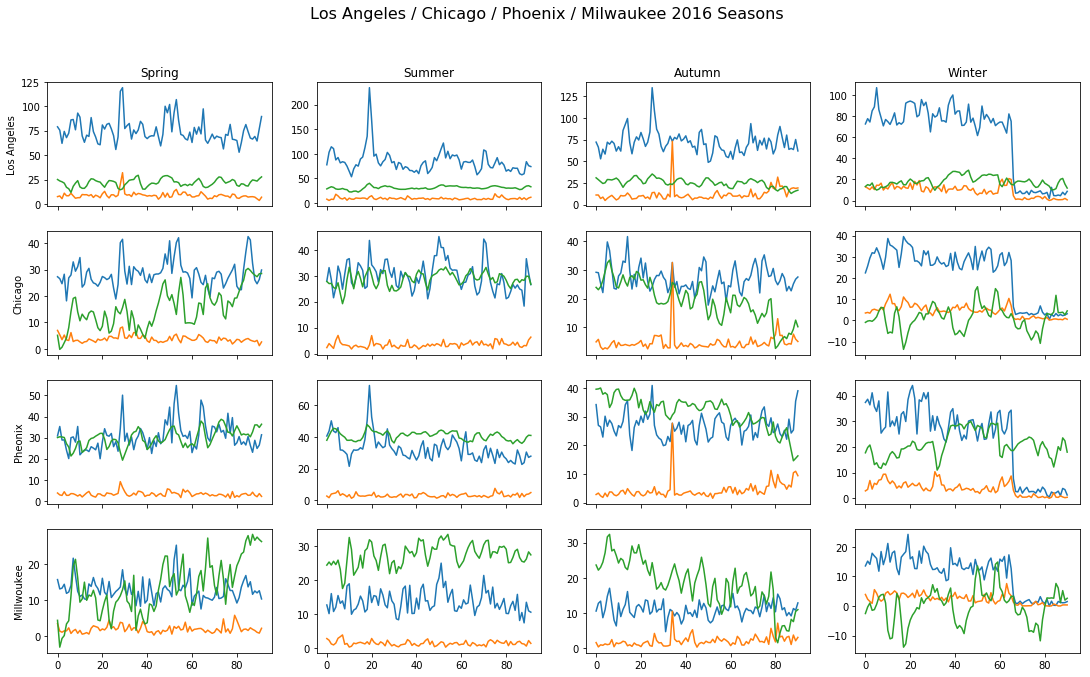

In [491]:
## Plot the same line charts based on seasons
year='2016'
spring_rng=[d.strftime('%Y%m%d') for d in pd.date_range('2016-3-1', periods=92, freq='D')]
summer_rng=[d.strftime('%Y%m%d') for d in pd.date_range('2016-6-1', periods=92, freq='D')]
autumn_rng=[d.strftime('%Y%m%d') for d in pd.date_range('2016-9-1', periods=91, freq='D')]
winter_rng=[d.strftime('%Y%m%d') for d in pd.date_range('2016-1-1', periods=60, freq='D')]+[d.strftime('%Y%m%d') for d in pd.date_range('2016-12-1', periods=31, freq='D')]

spring_index=[i for i,x in enumerate(county_hot_top_df.columns.values) if x in spring_rng]
summer_index=[i for i,x in enumerate(county_hot_top_df.columns.values) if x in summer_rng]
autumn_index=[i for i,x in enumerate(county_hot_top_df.columns.values) if x in autumn_rng]
winter_index=[i for i,x in enumerate(county_hot_top_df.columns.values) if x in winter_rng]

f, axarr = plt.subplots(4, 4, sharex=True)
f.suptitle('Los Angeles / Chicago / Phoenix / Milwaukee 2016 Seasons', fontsize=16)
f.set_size_inches(18.5, 10.5, forward=True)

axarr[0, 0].plot(np.array(la_hot_list)[spring_index],label='hot count')
axarr[0, 0].plot(np.array(la_cold_list)[spring_index], label='cold count')
axarr[0, 0].plot(np.array(la_tmax_list)[spring_index], label='tmax')
axarr[0, 1].plot(np.array(la_hot_list)[summer_index])
axarr[0, 1].plot(np.array(la_cold_list)[summer_index])
axarr[0, 1].plot(np.array(la_tmax_list)[summer_index])
axarr[0, 2].plot(np.array(la_hot_list)[autumn_index])
axarr[0, 2].plot(np.array(la_cold_list)[autumn_index])
axarr[0, 2].plot(np.array(la_tmax_list)[autumn_index])
axarr[0, 3].plot(np.array(la_hot_list)[winter_index])
axarr[0, 3].plot(np.array(la_cold_list)[winter_index])
axarr[0, 3].plot(np.array(la_tmax_list)[winter_index])
axarr[1, 0].plot(np.array(chi_hot_list)[spring_index])
axarr[1, 0].plot(np.array(chi_cold_list)[spring_index])
axarr[1, 0].plot(np.array(chi_tmax_list)[spring_index])
axarr[1, 1].plot(np.array(chi_hot_list)[summer_index])
axarr[1, 1].plot(np.array(chi_cold_list)[summer_index])
axarr[1, 1].plot(np.array(chi_tmax_list)[summer_index])
axarr[1, 2].plot(np.array(chi_hot_list)[autumn_index])
axarr[1, 2].plot(np.array(chi_cold_list)[autumn_index])
axarr[1, 2].plot(np.array(chi_tmax_list)[autumn_index])
axarr[1, 3].plot(np.array(chi_hot_list)[winter_index])
axarr[1, 3].plot(np.array(chi_cold_list)[winter_index])
axarr[1, 3].plot(np.array(chi_tmax_list)[winter_index])
axarr[2, 0].plot(np.array(phi_hot_list)[spring_index])
axarr[2, 0].plot(np.array(phi_cold_list)[spring_index])
axarr[2, 0].plot(np.array(phi_tmax_list)[spring_index])
axarr[2, 1].plot(np.array(phi_hot_list)[summer_index])
axarr[2, 1].plot(np.array(phi_cold_list)[summer_index])
axarr[2, 1].plot(np.array(phi_tmax_list)[summer_index])
axarr[2, 2].plot(np.array(phi_hot_list)[autumn_index])
axarr[2, 2].plot(np.array(phi_cold_list)[autumn_index])
axarr[2, 2].plot(np.array(phi_tmax_list)[autumn_index])
axarr[2, 3].plot(np.array(phi_hot_list)[winter_index])
axarr[2, 3].plot(np.array(phi_cold_list)[winter_index])
axarr[2, 3].plot(np.array(phi_tmax_list)[winter_index])
axarr[3, 0].plot(np.array(mil_hot_list)[spring_index])
axarr[3, 0].plot(np.array(mil_cold_list)[spring_index])
axarr[3, 0].plot(np.array(mil_tmax_list)[spring_index])
axarr[3, 1].plot(np.array(mil_hot_list)[summer_index])
axarr[3, 1].plot(np.array(mil_cold_list)[summer_index])
axarr[3, 1].plot(np.array(mil_tmax_list)[summer_index])
axarr[3, 2].plot(np.array(mil_hot_list)[autumn_index])
axarr[3, 2].plot(np.array(mil_cold_list)[autumn_index])
axarr[3, 2].plot(np.array(mil_tmax_list)[autumn_index])
axarr[3, 3].plot(np.array(mil_hot_list)[winter_index])
axarr[3, 3].plot(np.array(mil_cold_list)[winter_index])
axarr[3, 3].plot(np.array(mil_tmax_list)[winter_index])

seasons=['Spring','Summer','Autumn','Winter']
cities=['Los Angeles','Chicago','Pheonix','Millwoukee']
for ax, col in zip(axarr[0], seasons):
    ax.set_title(col)

for ax, row in zip(axarr[:,0], cities):
    ax.set_ylabel(row, rotation=90,va='bottom')

